### Data Preparation

In [1]:
import pandas as pd
path = "C:/Users/nchong/OneDrive - Intel Corporation/Documents/ML based speckle POC/"
df = pd.read_csv(path+"SNR_R5_ww51.4.csv")

C:\Users\nchong\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (10,11,1310) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
df.shape

(53772, 1833)

In [3]:
#check for rows will blank delta
import numpy as np
df1 = df[df["DELTA"].isnull()]
df1

,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],FB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TX_EN_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD0_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD1_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_RMII_CLK_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_CLK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_TX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_WAKE_N_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_XTAL_VALID_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_PMSYNC_CPU
22481,M1XH703100536,N0366610_230_0_6,N0366610,N036661,230,0,6,H0311010_638_-6_-1,45,4543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22485,M1XH703100244,N0342520_276_-3_0,N0342520,N034252,276,-3,0,H0311010_638_-11_-10,27,2755,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22577,M1XH703100936,N0423170_659_-3_3,N0423170,N042317,659,-3,3,H0403340_372_2_13,21,2155,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22585,M1BH477201065,N0423170_700_3_-9,N0423170,N042317,700,3,-9,H0271700_785_14_1,9,997,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22624,M1XH703101227,N0422350_116_-3_-3,N0422350,N042235,116,-3,-3,H0403340_372_-4_-4,60,6005,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53524,M1MM581500781,N0423170_669_4_-2,N0423170,N042317,669,4,-2,H0311010_643_-6_-18,21,2150,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53543,M1MM581500722,N0446570_120_-4_6,N0446570,N044657,120,-4,6,H0311010_643_-5_2,61,6180,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53557,M1MM581500744,N0411290_435_4_4,N0411290,N041129,435,4,4,H0311010_567_5_18,45,4550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53652,M1JJ817501248,N0422200_050_6_2,N0422200,N042220,50,6,2,H0311010_568_1_-18,21,2148,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
path

'C:/Users/nchong/OneDrive - Intel Corporation/Documents/ML based speckle POC/'

In [74]:
#make folder for dataprep if it doesn't exist
import os
dataprep_path = path + 'DataPreparation/' 
if not os.path.exists(dataprep_path):
    os.makedirs(dataprep_path)
    print("DataPreparation folder created!")

In [75]:
df1.to_csv(dataprep_path+"Blank_delta.csv",index=False)

In [6]:
#remove blank delta
import numpy as np
df = df[df["DELTA"].notnull()]
df

,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],FB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TX_EN_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD0_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD1_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_RMII_CLK_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_CLK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_TX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_WAKE_N_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_XTAL_VALID_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_PMSYNC_CPU
0,M00C045U00024,N0284110_927_0_4,N0284110,N028411,927,0,4,H0206320_095_4_-4,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,M00C045U00050,N0292750_182_3_-6,N0292750,N029275,182,3,-6,H0206290_057_-5_-17,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,M00C045U00123,N0292750_221_-5_-5,N0292750,N029275,221,-5,-5,H0206290_057_0_-14,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,M00C045U00134,N0284110_927_-3_-8,N0284110,N028411,927,-3,-8,H0206320_095_4_-6,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,M00C045U00135,N0284110_927_4_-6,N0284110,N028411,927,4,-6,H0206320_095_4_-7,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53767,M1JJ817501153,N0422200_050_5_-2,N0422200,N042220,50,5,-2,H0311010_568_4_14,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53768,M1JJ817501233,N0422200_050_-3_1,N0422200,N042220,50,-3,1,H0311010_568_4_-11,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53769,M1JJ817501241,N0422200_050_0_4,N0422200,N042220,50,0,4,H0311010_568_4_-8,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53770,M1JJ817501242,N0422200_050_0_5,N0422200,N042220,50,0,5,H0311010_568_4_-9,1,101,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df["DELTA"].value_counts()

0.0    46342
1.0     6432
2.0      130
Name: DELTA, dtype: int64

In [8]:
#create new column for target
import numpy as np
df["SPECKLE"] = np.where(df["DELTA"]==0,0,1)
cols = df.columns.tolist()
cols = [cols[-1]]+cols[:-1] #move speckle col to the front
df = df.reindex(columns=cols)

In [9]:
df["SPECKLE"].value_counts()

0    46342
1     6562
Name: SPECKLE, dtype: int64

In [10]:
df.head()

,SPECKLE,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TX_EN_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD0_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD1_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_RMII_CLK_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_CLK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_TX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_WAKE_N_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_XTAL_VALID_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_PMSYNC_CPU
0,1,M00C045U00024,N0284110_927_0_4,N0284110,N028411,927,0,4,H0206320_095_4_-4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M00C045U00050,N0292750_182_3_-6,N0292750,N029275,182,3,-6,H0206290_057_-5_-17,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,M00C045U00123,N0292750_221_-5_-5,N0292750,N029275,221,-5,-5,H0206290_057_0_-14,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,M00C045U00134,N0284110_927_-3_-8,N0284110,N028411,927,-3,-8,H0206320_095_4_-6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,M00C045U00135,N0284110_927_4_-6,N0284110,N028411,927,4,-6,H0206320_095_4_-7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# pd.options.display.max_seq_items = 2000
# df.columns

In [11]:
df = df.reset_index(drop=True)
df.shape

(52904, 1834)

In [ ]:
# df.describe()

In [ ]:
df.to_csv(dataprep_path+"SNR_R5_ww51.4_Blankdeltarem.csv",index=False)

### 1) Check for VID duplicates (Unique VID)

In [12]:
df.shape

(52904, 1834)

In [13]:
df["SPECKLE"].value_counts()

0    46342
1     6562
Name: SPECKLE, dtype: int64

In [14]:
def check_duplicates(df):
    """
    Check for duplicates in VID 
    df[DataFrame]: input df    
    """
    if df['VID'].duplicated().any():
        print("There are duplicates in VID")
        df_dup = df[df.duplicated(subset=['VID'])] #get the duplicates in df, returns repeated rows only 
        df= df[df["VID"].isin(df_dup["VID"])] #get all the duplicates in df, returns original + repeated rows 
        return df
    else:
        print("There are no duplicates in VID")
    

In [15]:
df_dup = check_duplicates(df)
df_dup #78 rows of duplicates, 39 duplicated VIDs -> ONLY 1 VID has values, the rest all blanks

There are duplicates in VID


,SPECKLE,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TX_EN_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD0_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD1_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_RMII_CLK_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_CLK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_TX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_WAKE_N_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_XTAL_VALID_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_PMSYNC_CPU
10018,1,M13N2V2900237,N0395200_215_3_1,N0395200,N039520,215,3,1,H0271700_766_1_12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10061,1,M13N2V2900438,N0410300_364_-4_2,N0410300,N041030,364,-4,2,H0280420_608_-1_-3,60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10524,1,M14M6U9601241,N0371260_365_4_-2,N0371260,N037126,365,4,-2,H0403360_811_-8_-1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11372,1,M165W4T400428,N0371240_404_3_-7,N0371240,N037124,404,3,-7,H0403360_811_-3_-12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11373,1,M165W4T400910,N0395050_466_1_4,N0395050,N039505,466,1,4,H0402280_031_-2_15,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48381,1,M1VP888001021,N0382520_389_-2_-3,N0382520,N038252,389,-2,-3,H0403360_865_1_-22,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51467,1,M1N96V6800528,N0382620_355_2_7,N0382620,N038262,355,2,7,H0271700_768_-2_-11,14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51524,1,M1S523K900060,N0394880_119_-6_-2,N0394880,N039488,119,-6,-2,H0271700_768_15_2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51748,1,M1S523K900841,N0394900_180_-1_-1,N0394900,N039490,180,-1,-1,H0311010_648_-7_-4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_dup.to_csv(dataprep_path+"SNR_R5_ww51.4_DuplicateVID.csv",index=False)

In [16]:
df_dup_withval = df.loc[df['VID'] == 'M1BH477200042']
df_dup_withval

,SPECKLE,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TX_EN_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD0_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD1_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_RMII_CLK_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_CLK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_TX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_WAKE_N_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_XTAL_VALID_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_PMSYNC_CPU
13581,1,M1BH477200042,N0366610_224_-2_-5,N0366610,N036661,224,-2,-5,H0311010_638_-7_-21,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23429,1,M1BH477200042,N0366610_224_-2_-5,N0366610,N036661,224,-2,-5,H0311010_638_-7_-21,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
def duplicates_handling(df,keep):
    """
    Remove duplicates if there is any
    df[DataFrame]: input df
    keep: {‘first’, ‘last’, False}: Determines which duplicates (if any) to keep. 
    - first : Drop duplicates except for the first occurrence. 
    - last : Drop duplicates except for the last occurrence. 
    - False : Drop all duplicates.
    """
    df = df.drop_duplicates(subset=['VID'],keep=keep) #remove duplicates from df
#     display(df)
    return df

In [18]:
df = duplicates_handling(df,keep=False)
df = pd.concat([df, df_dup_withval], ignore_index=True)
df = duplicates_handling(df,keep="first")
df

,SPECKLE,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TX_EN_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD0_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_NCSI_TXD1_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_RMII_CLK_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_CLK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_RX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_SBLINK_TX_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_WAKE_N_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_NAC_XTAL_VALID_CPU,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_FC1@132110_PMSYNC_CPU
0,1,M00C045U00024,N0284110_927_0_4,N0284110,N028411,927,0,4,H0206320_095_4_-4,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,M00C045U00050,N0292750_182_3_-6,N0292750,N029275,182,3,-6,H0206290_057_-5_-17,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,M00C045U00123,N0292750_221_-5_-5,N0292750,N029275,221,-5,-5,H0206290_057_0_-14,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,M00C045U00134,N0284110_927_-3_-8,N0284110,N028411,927,-3,-8,H0206320_095_4_-6,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,M00C045U00135,N0284110_927_4_-6,N0284110,N028411,927,4,-6,H0206320_095_4_-7,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52822,0,M1JJ817501233,N0422200_050_-3_1,N0422200,N042220,50,-3,1,H0311010_568_4_-11,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52823,0,M1JJ817501241,N0422200_050_0_4,N0422200,N042220,50,0,4,H0311010_568_4_-8,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52824,0,M1JJ817501242,N0422200_050_0_5,N0422200,N042220,50,0,5,H0311010_568_4_-9,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52825,0,M1JJ817501234,N0422200_050_-3_0,N0422200,N042220,50,-3,0,H0311010_568_4_-12,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
check_duplicates(df)

There are no duplicates in VID


In [20]:
df["SPECKLE"].value_counts()

0    46342
1     6485
Name: SPECKLE, dtype: int64

### 2 ) NA handling (NA removal/imputation)

In [21]:
# check column for nulls
def check_colna(df):
    """
    Check each column for nulls. Returns Feature, total null and % of null for each column
    df[DataFrame]: dataframe
    
    """
    colna_df = pd.DataFrame(columns =["Feature", "Total Null", "% of Null"])
    for col in df.columns: 
        #checking if there is any null in the column

        if df[col].isnull().sum()>0: 
            
            # if null present, total number of null in the column stores here
            total_null = df[col].isnull().sum() 
            new_row = {'Feature':col, 'Total Null':total_null, '% of Null':total_null*100/len(df)}
            #append row to the dataframe
            colna_df = colna_df.append(new_row, ignore_index=True)
            
    colna_df= colna_df.sort_values("% of Null", ascending=False)    
    return colna_df  

# check rows for nulls
def check_rowna(df,supporting_fs):  
    """
    Check each row for nulls.Returns VID, total null and % of null for each row
    df[DataFrame]: dataframe
    supporting_fs[list]: all features not used for ML except VID and SPECKLE(target)
    """
    df = df.drop(supporting_fs,axis=1)    
    colrow_df = pd.DataFrame(columns =["SPECKLE","VID", "Total Null", "% of Null"])
    for i in df.index: 
        #checking if there is any null in the row
        if df.iloc[i].isnull().sum()>0:             
            # if null present, total number of null in the row stores here
            total_null = df.iloc[i].isnull().sum() 
            new_row = {'SPECKLE':df.iloc[i,0],'VID':df.iloc[i,1], 'Total Null':total_null, '% of Null':round(total_null*100/(len(df.columns)-2),2)}
            #append row to the dataframe
            colrow_df = colrow_df.append(new_row, ignore_index=True)
            
    colrow_df= colrow_df.sort_values("% of Null", ascending=False)    
    return colrow_df   

# Drop columns based on NA threshold limit
def drop_NAcol(df,NA_limit):
    '''
    Drops columns based on proportion of NA in column
    df[DataFrame]: df
    NA_limit[float/int]: Columns with proportion of NA above NA_limit will be dropped
    '''
    threshold = len(df)*(1-NA_limit)
    df=df.dropna(axis=1, thresh=threshold)
    print(df.shape)
    return df


#### a) Check column for nulls

In [22]:
print(df.shape)
print(df["SPECKLE"].value_counts())

(52827, 1834)
0    46342
1     6485
Name: SPECKLE, dtype: int64


#### i) check nulls in whole column 

In [23]:
#check column na for whole df
colna_df =check_colna(df)
colna_df

,Feature,Total Null,% of Null
1812,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.000000
1308,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.000000
1316,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.000000
1315,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.000000
1314,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.000000
...,...,...,...
1497,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1496,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1495,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1494,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731


In [24]:
#check columns with 100% NA
colna_df.loc[colna_df["% of Null"] ==100]

,Feature,Total Null,% of Null
1812,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
1308,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
1316,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
1315,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
1314,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
...,...,...,...
1760,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
1756,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
1757,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0
1758,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_F...,52827,100.0


In [ ]:
colna_df.to_csv(dataprep_path+"NA_Cols.csv",index=False)

In [27]:
#drop columns with all NA
df = df.dropna(axis=1, how='all')
df.shape

(52827, 1660)

In [28]:
check_colna(df)

,Feature,Total Null,% of Null
1024,TPI_VCC::CONT_VCCVNN_HC_E_ETEND_X_X_X_X_POSTSU...,52825,99.996214
997,TPI_VCC::CONT_VCCDDRDQ_HC_K_ETEND_X_X_X_X_SNR_...,52825,99.996214
1025,TPI_VCC::CONT_VCCVNN_HC_E_ETEND_X_X_X_X_SNR_MI...,52825,99.996214
967,TPI_VCC::CONT_VCCCLM_HC_K_ETEND_X_X_X_X_SNR_OL...,52825,99.996214
970,TPI_VCC::CONT_VCCCOREM01_HC_E_ETEND_X_X_X_X_PO...,52825,99.996214
...,...,...,...
1460,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1459,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1458,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1457,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731


#### ii) check nulls in column for speckle only

In [29]:
df.shape

(52827, 1660)

In [30]:
#check column na for speckle
colna_speckle_df =check_colna(df.loc[df['SPECKLE'] == 1])
colna_speckle_df

,Feature,Total Null,% of Null
1007,TPI_VCC::CONT_VCCINF_HC_E_ETEND_X_X_X_X_SNR_MI...,6485,100.000000
961,TPI_VCC::CONT_VCCCLM_HC_E_ETEND_X_X_X_X_POSTSU...,6485,100.000000
970,TPI_VCC::CONT_VCCCOREM01_HC_E_ETEND_X_X_X_X_PO...,6485,100.000000
971,TPI_VCC::CONT_VCCCOREM01_HC_E_ETEND_X_X_X_X_SN...,6485,100.000000
1066,TPI_VCC::CONT_X_SCREEN_K_ETEND_X_X_X_X_SNR_ADT...,6485,100.000000
...,...,...,...
1458,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421
1457,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421
1456,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421
1455,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421


In [31]:
len(colna_speckle_df.loc[colna_speckle_df["% of Null"] ==100])

26

In [ ]:
colna_speckle_df.to_csv(path+"/DataPreparation/NA_Cols_speckle.csv",index=False)

In [32]:
col100na_speckle_df = colna_speckle_df.loc[colna_speckle_df["% of Null"] ==100]
df = df.loc[:,~df.columns.isin(col100na_speckle_df['Feature'])]
df.shape

(52827, 1634)

In [33]:
colna_speckle_df =check_colna(df.loc[df['SPECKLE'] == 1])
colna_speckle_df

,Feature,Total Null,% of Null
1015,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,6484,99.984580
1017,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,6482,99.953739
1043,TPI_VCC::CONT_X_SCREEN_K_FINAL_X_X_X_X_SNR_ADT...,6480,99.922899
1011,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_ADT...,6480,99.922899
1041,TPI_VCC::CONT_X_SCREEN_K_FINAL_X_X_X_X_SNR_ADT...,6480,99.922899
...,...,...,...
1439,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421
1438,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421
1437,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421
1436,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,4694,72.382421


#### iii) check nulls in column for non-speckle only

In [34]:
#check column na for non-speckle
colna_nonspeckle_df =check_colna(df.loc[df['SPECKLE'] == 0])
colna_nonspeckle_df

,Feature,Total Null,% of Null
1019,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,46340,99.995684
1015,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,46332,99.978421
1017,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,46332,99.978421
1013,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,46286,99.879159
1009,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_ADT...,46284,99.874844
...,...,...,...
788,TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SN...,32336,69.776876
790,TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SN...,32336,69.776876
792,TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SN...,32336,69.776876
794,TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SN...,32336,69.776876


In [35]:
#check column na for whole df
colna_df_no100NA =check_colna(df)
colna_df_no100NA

,Feature,Total Null,% of Null
1019,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,52820,99.986749
1015,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,52816,99.979177
1017,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_VCC...,52814,99.975391
1042,TPI_VCC::CONT_X_SCREEN_K_FINAL_X_X_X_X_SNR_ADT...,52764,99.880743
1011,TPI_VCC::CONT_X_SCREEN_E_FINAL_X_X_X_X_SNR_ADT...,52764,99.880743
...,...,...,...
1439,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1438,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1437,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1436,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731


In [36]:
df.shape

(52827, 1634)

In [ ]:
colna_df_no100NA.to_csv(path+"/DataPreparation/NA_Cols_without100NA.csv",index=False)

#### b) Drop columns based on threshold limit

In [37]:
df = drop_NAcol(df,0.8) #drop columns with >80% NA 

(52827, 1549)


In [38]:
df.shape

(52827, 1549)

In [39]:
check_colna(df)

,Feature,Total Null,% of Null
741,HVQK_VMIN_PRE_SCAN_UNCORE_VNN@132110,41616,78.777898
1165,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,39829,75.395158
0,IDV_0001_SVT3GNES12_FULLDIE_SOC_0650_MED@132110,37527,71.037538
399,IDV_0134_PSVT3GVTO12_FULLDIE_TALL_0950_MED@132110,37527,71.037538
392,IDV_0134_PSVT3GVTO12_FULLDIE_CORE_TALL_0650_ME...,37527,71.037538
...,...,...,...
1355,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1354,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1353,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731
1352,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,37030,70.096731


#### c) Check row for nulls

In [40]:
print(df.shape)
print(df["SPECKLE"].value_counts())

(52827, 1549)
0    46342
1     6485
Name: SPECKLE, dtype: int64


In [ ]:
pd.options.display.max_seq_items = 2000
df.columns

In [41]:
supporting_fs = ['ULT@MIDAS_6261_U1', 'SORTLOT', 'SORTLOT7', 'WAFER',
       'XLOC', 'YLOC', 'ULT@MIDAS_6261_U2', 'IB@6261[CLASSHOT]',
       'FB@6261[CLASSHOT]', 'TEST RESULTS', 'TEST RESULTS BITS', 'TR_BITS',
       'INCOMING', 'INCOMING BITS', 'INC_BITS', 'OUTGOING', 'OUTGOING BITS',
       'OUT_BITS', 'DELTA']
rowna_df = check_rowna(df,supporting_fs)
rowna_df

,SPECKLE,VID,Total Null,% of Null
0,1,M00C045U00024,1528,100.00
28763,0,M1KM000200659,1528,100.00
28755,0,M1KM000200053,1528,100.00
28756,0,M1KM000201498,1528,100.00
28757,0,M1KM000200052,1528,100.00
...,...,...,...,...
7788,0,M12C2P5801224,1,0.07
7789,1,M12C2P5801227,1,0.07
7790,0,M12C2P5801228,1,0.07
7791,0,M12C2P5801229,1,0.07


In [42]:
#get rows with 100% NA
row100na_df = rowna_df.loc[rowna_df["% of Null"] ==100.00]
row100na_df

,SPECKLE,VID,Total Null,% of Null
0,1,M00C045U00024,1528,100.0
28763,0,M1KM000200659,1528,100.0
28755,0,M1KM000200053,1528,100.0
28756,0,M1KM000201498,1528,100.0
28757,0,M1KM000200052,1528,100.0
...,...,...,...,...
14367,0,M1DY252001733,1528,100.0
20208,1,M1WR066400846,1528,100.0
20195,1,M1WR066400692,1528,100.0
20196,1,M1WR066400696,1528,100.0


In [ ]:
row100na_df.to_csv(dataprep_path+"NA_Rows.csv",index=False)

In [43]:
row100na_df["SPECKLE"].value_counts()

0    32336
1     4694
Name: SPECKLE, dtype: int64

#### d) Row NA handling

In [44]:
#drop rows with 100% NA
df = df[~df["VID"].isin(row100na_df["VID"])]
df = df.reset_index(drop=True)
df

,SPECKLE,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDCLK1,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA0,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA1,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_DIS_STRAP_N,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_ODT_EN,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_AGENT,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_PLTEN,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSCL,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSDA,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VSENSEPMAX
0,1,M0118LB500624,N0293010_594_1_9,N0293010,N029301,594,1,9,H0235270_643_8_13,1,...,-7.900000e-07,-7.830000e-07,-8.270000e-07,-1.800000e-07,-2.040000e-07,-1.950000e-07,-2.240000e-07,-7.780000e-07,-7.550000e-07,-1.720000e-07
1,1,M0118LB500644,N0293010_594_3_3,N0293010,N029301,594,3,3,H0235270_643_11_8,1,...,-1.200000e-06,-1.200000e-06,-1.220000e-06,-2.890000e-07,-2.990000e-07,-3.080000e-07,-3.020000e-07,-1.200000e-06,-1.200000e-06,-3.310000e-07
2,1,M0118LB500649,N0293010_594_-3_-5,N0293010,N029301,594,-3,-5,H0235270_643_11_13,1,...,-9.390000e-07,-9.470000e-07,-9.390000e-07,-2.350000e-07,-2.280000e-07,-2.400000e-07,-2.290000e-07,-9.430000e-07,-9.530000e-07,-2.490000e-07
3,1,M0118LB500823,N0293010_594_5_-3,N0293010,N029301,594,5,-3,H0235270_643_11_6,14,...,-1.110000e-06,-1.210000e-06,-1.240000e-06,-2.830000e-07,-2.980000e-07,-3.090000e-07,-2.900000e-07,-1.210000e-06,-1.130000e-06,-2.990000e-07
4,1,M0118LB500903,N0293010_585_-6_-3,N0293010,N029301,585,-6,-3,H0235270_643_14_5,1,...,-6.380000e-07,-6.860000e-07,-6.600000e-07,-1.560000e-07,-1.700000e-07,-1.630000e-07,-1.470000e-07,-6.330000e-07,-6.490000e-07,-1.500000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15792,0,M1JJ817501233,N0422200_050_-3_1,N0422200,N042220,50,-3,1,H0311010_568_4_-11,1,...,-7.840000e-07,-7.520000e-07,-7.590000e-07,-1.610000e-07,-1.760000e-07,-1.860000e-07,-1.970000e-07,-7.280000e-07,-7.510000e-07,-1.860000e-07
15793,0,M1JJ817501241,N0422200_050_0_4,N0422200,N042220,50,0,4,H0311010_568_4_-8,1,...,-8.900000e-07,-8.520000e-07,-8.660000e-07,-2.130000e-07,-2.040000e-07,-2.200000e-07,-2.290000e-07,-8.970000e-07,-9.040000e-07,-2.050000e-07
15794,0,M1JJ817501242,N0422200_050_0_5,N0422200,N042220,50,0,5,H0311010_568_4_-9,1,...,-7.590000e-07,-7.500000e-07,-7.660000e-07,-1.910000e-07,-1.810000e-07,-1.960000e-07,-1.950000e-07,-8.120000e-07,-8.170000e-07,-1.990000e-07
15795,0,M1JJ817501234,N0422200_050_-3_0,N0422200,N042220,50,-3,0,H0311010_568_4_-12,1,...,-8.870000e-07,-8.530000e-07,-8.720000e-07,-2.170000e-07,-1.960000e-07,-2.090000e-07,-2.180000e-07,-8.270000e-07,-8.250000e-07,-2.320000e-07


In [45]:
df["SPECKLE"].value_counts()

0    14006
1     1791
Name: SPECKLE, dtype: int64

In [46]:
df.shape

(15797, 1549)

In [47]:
#check row na
supporting_fs = ['ULT@MIDAS_6261_U1', 'SORTLOT', 'SORTLOT7', 'WAFER',
       'XLOC', 'YLOC', 'ULT@MIDAS_6261_U2', 'IB@6261[CLASSHOT]',
       'FB@6261[CLASSHOT]', 'TEST RESULTS', 'TEST RESULTS BITS', 'TR_BITS',
       'INCOMING', 'INCOMING BITS', 'INC_BITS', 'OUTGOING', 'OUTGOING BITS',
       'OUT_BITS', 'DELTA']
check_rowna(df,supporting_fs)

,SPECKLE,VID,Total Null,% of Null
3472,1,M1888SS100619,1245,81.48
3468,1,M1888SS100611,1245,81.48
3478,1,M1888SS100734,1245,81.48
3477,1,M1888SS100708,1245,81.48
3476,1,M1888SS100706,1245,81.48
...,...,...,...,...
2823,1,M12C2P5800956,1,0.07
2824,0,M12C2P5800963,1,0.07
2825,0,M12C2P5800967,1,0.07
2826,0,M12C2P5800969,1,0.07


In [ ]:
# df = df.drop(['PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_CDYN_INDICATOR_CDYN_DATA@132110'],axis=1)

In [48]:
df.shape

(15797, 1549)

In [49]:
#NA imputation
def NA_impute(df,imptype):
    """
    Impute NA
    df[DataFrame]:df
    imptype[string]: "mean" to impute data with mean, "median" to impute data with median
    """
    if imptype == "mean":        
        df = df.fillna(df.mean())
    if imptype == "median":
        df = df.fillna(df.median())
    return df

In [50]:
df = NA_impute(df,imptype="median")
df

,SPECKLE,VID,ULT@MIDAS_6261_U1,SORTLOT,SORTLOT7,WAFER,XLOC,YLOC,ULT@MIDAS_6261_U2,IB@6261[CLASSHOT],...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDCLK1,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA0,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA1,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_DIS_STRAP_N,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_ODT_EN,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_AGENT,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_PLTEN,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSCL,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSDA,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VSENSEPMAX
0,1,M0118LB500624,N0293010_594_1_9,N0293010,N029301,594,1,9,H0235270_643_8_13,1,...,-7.900000e-07,-7.830000e-07,-8.270000e-07,-1.800000e-07,-2.040000e-07,-1.950000e-07,-2.240000e-07,-7.780000e-07,-7.550000e-07,-1.720000e-07
1,1,M0118LB500644,N0293010_594_3_3,N0293010,N029301,594,3,3,H0235270_643_11_8,1,...,-1.200000e-06,-1.200000e-06,-1.220000e-06,-2.890000e-07,-2.990000e-07,-3.080000e-07,-3.020000e-07,-1.200000e-06,-1.200000e-06,-3.310000e-07
2,1,M0118LB500649,N0293010_594_-3_-5,N0293010,N029301,594,-3,-5,H0235270_643_11_13,1,...,-9.390000e-07,-9.470000e-07,-9.390000e-07,-2.350000e-07,-2.280000e-07,-2.400000e-07,-2.290000e-07,-9.430000e-07,-9.530000e-07,-2.490000e-07
3,1,M0118LB500823,N0293010_594_5_-3,N0293010,N029301,594,5,-3,H0235270_643_11_6,14,...,-1.110000e-06,-1.210000e-06,-1.240000e-06,-2.830000e-07,-2.980000e-07,-3.090000e-07,-2.900000e-07,-1.210000e-06,-1.130000e-06,-2.990000e-07
4,1,M0118LB500903,N0293010_585_-6_-3,N0293010,N029301,585,-6,-3,H0235270_643_14_5,1,...,-6.380000e-07,-6.860000e-07,-6.600000e-07,-1.560000e-07,-1.700000e-07,-1.630000e-07,-1.470000e-07,-6.330000e-07,-6.490000e-07,-1.500000e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15792,0,M1JJ817501233,N0422200_050_-3_1,N0422200,N042220,50,-3,1,H0311010_568_4_-11,1,...,-7.840000e-07,-7.520000e-07,-7.590000e-07,-1.610000e-07,-1.760000e-07,-1.860000e-07,-1.970000e-07,-7.280000e-07,-7.510000e-07,-1.860000e-07
15793,0,M1JJ817501241,N0422200_050_0_4,N0422200,N042220,50,0,4,H0311010_568_4_-8,1,...,-8.900000e-07,-8.520000e-07,-8.660000e-07,-2.130000e-07,-2.040000e-07,-2.200000e-07,-2.290000e-07,-8.970000e-07,-9.040000e-07,-2.050000e-07
15794,0,M1JJ817501242,N0422200_050_0_5,N0422200,N042220,50,0,5,H0311010_568_4_-9,1,...,-7.590000e-07,-7.500000e-07,-7.660000e-07,-1.910000e-07,-1.810000e-07,-1.960000e-07,-1.950000e-07,-8.120000e-07,-8.170000e-07,-1.990000e-07
15795,0,M1JJ817501234,N0422200_050_-3_0,N0422200,N042220,50,-3,0,H0311010_568_4_-12,1,...,-8.870000e-07,-8.530000e-07,-8.720000e-07,-2.170000e-07,-1.960000e-07,-2.090000e-07,-2.180000e-07,-8.270000e-07,-8.250000e-07,-2.320000e-07


In [51]:
check_rowna(df,supporting_fs)

,SPECKLE,VID,Total Null,% of Null


### 3) Handling of negative values (Imputation/conversion)

### 4) Check and remove unary(single value) columns

In [52]:
def unary(df):
    """
    Checks for unary columns. If there are unary columns, the unary columns will be printed and removed from the df
    df[DataFrame]: input dataframe
    """
    unarycolumns = [col for col in df.columns if len(df[col].unique())==1]
    if unarycolumns:
        print("The unary column are:",unarycolumns)
        df = df.drop(unarycolumns,axis=1)
        print("Unary columns dropped!")
        return df 
    else:
        print("There are no unary columns!")

In [53]:
unary(df)

There are no unary columns!


In [ ]:
# supporting_fs = ['SPECKLE','VID','ULT@MIDAS_6261_U1', 'SORTLOT', 'SORTLOT7', 'WAFER',
#        'XLOC', 'YLOC', 'ULT@MIDAS_6261_U2', 'IB@6261[CLASSHOT]',
#        'FB@6261[CLASSHOT]','ARR_SPECKLE_SCREEN::PHYTON_X_USERFUNC_K_END_X_X_X_X_PBISTSPECKLE_INDICATOR::DUTCPUBAD_1@6261[CLASSHOT]',
#        'TEST RESULTS', 'TEST RESULTS BITS', 'TR_BITS', 'INCOMING',
#        'INCOMING BITS', 'INC_BITS', 'OUTGOING', 'OUTGOING BITS', 'OUT_BITS','DELTA']
# sf_df = df[supporting_fs]
# df1 = df.drop(supporting_fs,axis=1) 
# df2 = df1.drop(['PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_CDYN_INDICATOR_CDYN_DATA@132110'],axis=1)
# df_neg = df2.loc[:,((df2 == -555).any()) | ((df2 == -999).any())]
# df_neg_sf = pd.concat([sf_df,df_neg],axis=1)
# df_neg_sf

In [ ]:
# df1.columns.difference(df2.columns)

In [ ]:
# df1['PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_CDYN_INDICATOR_CDYN_DATA@132110']

In [ ]:
# df2 = df1.drop(['PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_CDYN_INDICATOR_CDYN_DATA@132110'],axis=1)
# df_neg = df2.loc[:,((df2 == -555).any()) | ((df2 == -999).any())]

In [ ]:
# df_neg_sf = pd.concat([sf_df,df_neg],axis=1)
# df_neg_sf

In [ ]:
# df_neg_sf.to_csv(path+"/DataPreparation/Negative_Cols_555_999.csv",index=False)

### 5) Split data into train and validation datasets 

In [54]:
from sklearn.model_selection import train_test_split
from collections import Counter
def randomsamp(df,val_size):
    """
    Split whole dataset into train and validation using random sampling
    Returns X_train, X_val, y_train, y_val
    df[DataFrame]: input dataframe    
    val_size[float]:Should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the val split. 
                    Train size is complement of val size
    """
    X= df.drop(["SPECKLE"],axis=1)
    y= df["SPECKLE"] 
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = val_size,random_state=42,stratify= df["SPECKLE"])
    if type(val_size)==float:
        print("Train-val split completed with",(1-val_size)*100,"-",val_size*100,"split in train-val")
    print("Shape of X_train is:", X_train.shape)
    print("Shape of X_val is:",X_val.shape)
    print("Shape of y_train is:",y_train.shape)
    print("Shape of y_val is:",y_val.shape)
    print("Distribution of y_train:",Counter(y_train))
    print("Distribution of y_val:",Counter(y_val))
    
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)        
           
    return X_train, X_val, y_train, y_val

def targetrandomsamp(df,speckle_test_size,nonspeckle_test_size):
    """
    Dataset is split into speckle/non-speckle first. The speckle/non-speckle datasets are then split 
    into train and validation using random sampling, followed by merging of the speckle/non-speckle  
    to return X_train, X_val, y_train, y_val
    
    df[DataFrame]: input dataframe  
    
    speckle_test_size[float/int]: Val size for speckle 
    -If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the val split. 
    -If int, represents the absolute number of val samples.
    -Train size is complement of val size
    
    nonspeckle_test_size[float/int]: Val size for non-speckle 
    -If float, should be between 0.0 and 1.0 and represent the proportion of the dataset to include in the val split. 
    -If int, represents the absolute number of val samples.
    -Train size is complement of val size
    
    """
    #split data into speckle/nonspeckle
    df_s = df.loc[df["SPECKLE"] == 1] #speckle
    df_ns = df.loc[df["SPECKLE"] == 0] #nonspeckle
    
    #split speckle/nonspeckle data into train/validation
    print("For speckle data:")
    X_train_s, X_val_s, y_train_s, y_val_s = randomsamp(df_s,val_size=speckle_test_size)
    print("\nFor non-speckle data:")
    X_train_ns, X_val_ns, y_train_ns, y_val_ns = randomsamp(df_ns,val_size=nonspeckle_test_size)
    
    #concat the speckle/non-speckle train and validation
    X_train = pd.concat([X_train_s,X_train_ns], ignore_index=True)
    X_val = pd.concat([X_val_s,X_val_ns], ignore_index=True)
    y_train = pd.concat([y_train_s,y_train_ns], ignore_index=True)
    y_val = pd.concat([y_val_s,y_val_ns], ignore_index=True)
    
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_val = y_val.reset_index(drop=True)  
    
    print("\nFinal dataset:")
    print("Distribution of y_train:",Counter(y_train))
    print("Distribution of y_val:",Counter(y_val))
    return X_train, X_val, y_train, y_val

In [55]:
df["SPECKLE"].value_counts()

0    14006
1     1791
Name: SPECKLE, dtype: int64

In [56]:
#train-test split on whole data
X_train, X_val, y_train,y_val = randomsamp(df,val_size=0.3)

Train-val split completed with 70.0 - 30.0 split in train-val
Shape of X_train is: (11057, 1548)
Shape of X_val is: (4740, 1548)
Shape of y_train is: (11057,)
Shape of y_val is: (4740,)
Distribution of y_train: Counter({0: 9803, 1: 1254})
Distribution of y_val: Counter({0: 4203, 1: 537})


In [ ]:
#train-test split on speckle/non-speckle then merge
X_train, X_val, y_train, y_val = targetrandomsamp(df,speckle_test_size=500,nonspeckle_test_size=2000)

### 6) Remove supporting features

In [57]:
supporting_fs = ['VID','ULT@MIDAS_6261_U1', 'SORTLOT', 'SORTLOT7', 'WAFER',
       'XLOC', 'YLOC', 'ULT@MIDAS_6261_U2', 'IB@6261[CLASSHOT]',
       'FB@6261[CLASSHOT]', 'TEST RESULTS', 'TEST RESULTS BITS', 'TR_BITS',
       'INCOMING', 'INCOMING BITS', 'INC_BITS', 'OUTGOING', 'OUTGOING BITS',
       'OUT_BITS', 'DELTA']
X_train_sf = X_train[supporting_fs] #keep supporting fs of X_train
X_val_sf = X_val[supporting_fs] #keep supporting fs of X_val
X_train = X_train.drop(supporting_fs,axis=1) #remove supporting fs from X_train
X_val = X_val.drop(supporting_fs,axis=1) #remove supporting fs from X_val

### 7) Scaling the data (Standardization/Normalization)

In [60]:
#To scale X train and X validation (test) data using various scalers
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def scale_data(X_train,X_val,scaler_type):
    """
    Scaling X train and validation with standardization or normalization
    params:
    X_train[DataFrame]: input X train
    X_val[DataFrame]: input X validation (test)
    scaler_type[None/string]: input scaling method
    - "Standardization" for Standard Scaler
    - "Normalization" for Min Max Scaler    

    """           
    if scaler_type == "Standardization":
        scaler = StandardScaler()
    if scaler_type == "Normalization":
        scaler = MinMaxScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_train_scaled = pd.DataFrame(X_train_scaled,columns= X_train.columns)
    X_val_scaled = scaler.transform(X_val)
    X_val_scaled = pd.DataFrame(X_val_scaled,columns= X_val.columns)
       
    return X_train_scaled, X_val_scaled

In [61]:
#X train-test scaled using Min max Scaler
X_train_scaled, X_val_scaled = scale_data(X_train,X_val,scaler_type = "Normalization")

### 8) Handling highly correlated features (features vs features/features vs target)

#### a) features vs features

In [62]:
import time
import numpy as np
start = time.time()

#To create correlation matrix for X_train (features)
correlation_matrix = X_train_scaled.corr().abs()

#To select the upper trigular matrix from the correlation matrix of features
upper_tri = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape),k=1).astype(np.bool))
display(upper_tri)

highly_corr_features_95 = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

end = time.time()
print ("Time elapsed:", end - start)

,IDV_0001_SVT3GNES12_FULLDIE_SOC_0650_MED@132110,IDV_0001_SVT3GNES12_FULLDIE_SOC_0950_MED@132110,IDV_0001_SVT3GNES12_FULLDIE_SOC_TALL_0650_MED@132110,IDV_0001_SVT3GNES12_FULLDIE_SOC_TALL_0950_MED@132110,IDV_0002_SVT3GNES12_FULLDIE_SOC_0650_MED@132110,IDV_0002_SVT3GNES12_FULLDIE_SOC_0950_MED@132110,IDV_0002_SVT3GNES12_FULLDIE_SOC_TALL_0650_MED@132110,IDV_0002_SVT3GNES12_FULLDIE_SOC_TALL_0950_MED@132110,IDV_0003_SVT3GSEM12_FULLDIE_SOC_0650_MED@132110,IDV_0003_SVT3GSEM12_FULLDIE_SOC_0950_MED@132110,...,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDCLK1,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA0,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA1,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_DIS_STRAP_N,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_ODT_EN,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_AGENT,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_PLTEN,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSCL,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSDA,SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VSENSEPMAX
IDV_0001_SVT3GNES12_FULLDIE_SOC_0650_MED@132110,NaN,0.868735,0.987807,0.859943,0.993203,0.864404,0.988577,0.860186,0.966425,0.880205,...,0.309225,0.309365,0.303720,0.321451,0.312542,0.299867,0.320903,0.317833,0.319565,0.298829
IDV_0001_SVT3GNES12_FULLDIE_SOC_0950_MED@132110,NaN,NaN,0.845182,0.978709,0.862043,0.990492,0.846372,0.979920,0.784824,0.978133,...,0.123406,0.121733,0.116536,0.149820,0.135304,0.123537,0.140998,0.131474,0.135534,0.118892
IDV_0001_SVT3GNES12_FULLDIE_SOC_TALL_0650_MED@132110,NaN,NaN,NaN,0.862396,0.988971,0.848499,0.997312,0.859264,0.968519,0.866731,...,0.330176,0.329777,0.324308,0.343271,0.333093,0.321664,0.342263,0.340622,0.341795,0.321567
IDV_0001_SVT3GNES12_FULLDIE_SOC_TALL_0950_MED@132110,NaN,NaN,NaN,NaN,0.860488,0.980186,0.860316,0.995952,0.783824,0.966606,...,0.120242,0.118138,0.112746,0.148656,0.132052,0.121632,0.139770,0.130331,0.133665,0.117556
IDV_0002_SVT3GNES12_FULLDIE_SOC_0650_MED@132110,NaN,NaN,NaN,NaN,NaN,0.870074,0.988364,0.858741,0.967865,0.880156,...,0.314512,0.314516,0.309031,0.327707,0.318154,0.305870,0.327246,0.323458,0.324957,0.304563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_AGENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.944578,0.959699,0.958325,0.937625
SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_PLTEN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.958337,0.956548,0.934289
SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSCL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.990198,0.955880
SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.954151


Time elapsed: 61.90497875213623


In [78]:
len(highly_corr_features_95)

940

In [79]:
highly_corr_features_df = pd.DataFrame (highly_corr_features_95, columns = ['Feature'])
highly_corr_features_df.to_csv(path+"/DataPreparation/highly_corr_features_95.csv",index=False)

In [80]:
#Dropping the columns with high correlation
X_train_scaled = X_train_scaled.drop(highly_corr_features_95, axis=1)
X_train_scaled

KeyError: "['IDV_0001_SVT3GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0001_SVT3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0002_SVT3GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0002_SVT3GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0002_SVT3GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0002_SVT3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0003_SVT3GSEM12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0003_SVT3GSEM12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0003_SVT3GSEM12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0003_SVT3GSEM12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0004_NOM3GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0004_NOM3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0005_NOM3GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0005_NOM3GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0005_NOM3GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0005_NOM3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0006_SVT3GISO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0006_SVT3GISO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0006_SVT3GISO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0007_SVT1GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0007_SVT1GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0008_SVT1GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0008_SVT1GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0008_SVT1GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0008_SVT1GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0009_NOM1GISO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0009_NOM1GISO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0010_NOM2GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0010_NOM2GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0010_NOM2GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0010_NOM2GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0011_NOM2GSEM12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0011_NOM2GSEM12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0011_NOM2GSEM12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0011_NOM2GSEM12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0012_SVT1GISO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0012_SVT1GISO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0013_NOMNDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0013_NOMNDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0014_NOM3GAGN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0014_NOM3GAGN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0014_NOM3GAGN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0014_NOM3GAGN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0015_NOMPLK12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0015_NOMPLK12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0015_NOMPLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0016_SVTPLK12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0016_SVTPLK12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0016_SVTPLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0017_NOM2GNDN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0017_NOM2GNDN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0017_NOM2GNDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0017_NOM2GNDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0018_SVTNDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0018_SVTNDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0019_HVTNDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0019_HVTNDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0020_NOMPDN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0020_NOMPDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0020_NOMPDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0021_NOM4GPDN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0021_NOM4GPDN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0021_NOM4GPDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0021_NOM4GPDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0022_SVTPDN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0022_SVTPDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0022_SVTPDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0023_HVTPDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0023_HVTPDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0033_PHVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0033_PHVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0033_PHVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0034_PHVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0034_PHVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0034_PHVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0034_PHVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0035_PSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0035_PSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0035_PSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0036_PSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0036_PSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0036_PSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0036_PSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0037_PNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0037_PNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0037_PNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0038_PNOM3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0038_PNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0038_PNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0038_PNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0039_NHVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0039_NHVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0039_NHVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0039_NHVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0040_NHVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0040_NHVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0040_NHVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0040_NHVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0041_NSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0041_NSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0041_NSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0041_NSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0042_NSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0042_NSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0042_NSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0042_NSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0043_NNOM3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0043_NNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0043_NNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0043_NNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0044_NNOM3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0044_NNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0044_NNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0044_NNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0045_REFOMVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0045_REFOMVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0045_REFOMVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0045_REFOMVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0046_NOM3GAGN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0046_NOM3GAGN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0046_NOM3GAGN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0046_NOM3GAGN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0047_NOMNLK12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0047_NOMNLK12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0047_NOMNLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0048_SVTNLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0049_SVT2GNES8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0049_SVT2GNES8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0049_SVT2GNES8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0049_SVT2GNES8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0050_SVT2GNES8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0050_SVT2GNES8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0050_SVT2GNES8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0050_SVT2GNES8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0051_SVT2GSEM8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0051_SVT2GSEM8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0051_SVT2GSEM8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0051_SVT2GSEM8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0052_SVT1GNES8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0052_SVT1GNES8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0052_SVT1GNES8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0052_SVT1GNES8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0053_SVT1GSEM8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0053_SVT1GSEM8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0053_SVT1GSEM8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0053_SVT1GSEM8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0054_HVT1GNES8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0054_HVT1GNES8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0055_SVT1GISO8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0055_SVT1GISO8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0055_SVT1GISO8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0055_SVT1GISO8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0056_SVT1GISO8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0056_SVT1GISO8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0056_SVT1GISO8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0056_SVT1GISO8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0057_HVT1GISO8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0057_HVT1GISO8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0057_HVT1GISO8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0058_HVT1GISO8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0058_HVT1GISO8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0058_HVT1GISO8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0058_HVT1GISO8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0059_NOM3GAGN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0059_NOM3GAGN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0059_NOM3GAGN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0059_NOM3GAGN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0101_SVT3GNES12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0101_SVT3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0101_SVT3GNES12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0101_SVT3GNES12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0102_SVT3GNES12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0103_SVT3GSEM12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0104_NOM3GNES12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0104_NOM3GNES12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0104_NOM3GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0104_NOM3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0104_NOM3GNES12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0104_NOM3GNES12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0105_NOM3GNES12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0106_SVT3GISO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0107_SVT1GNES12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0107_SVT1GNES12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0107_SVT1GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0107_SVT1GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0107_SVT1GNES12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0107_SVT1GNES12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0108_SVT1GNES12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0109_NOM1GISO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0109_NOM1GISO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0109_NOM1GISO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0109_NOM1GISO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0109_NOM1GISO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0109_NOM1GISO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0110_NOM2GNES12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0111_NOM2GSEM12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0112_SVT1GISO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0112_SVT1GISO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0112_SVT1GISO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0112_SVT1GISO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0112_SVT1GISO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0112_SVT1GISO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0112_SVT1GISO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0113_NOMNDN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0113_NOMNDN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0113_NOMNDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0113_NOMNDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0113_NOMNDN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0113_NOMNDN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0114_NOM3GAGN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0115_NOMPLK12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0115_NOMPLK12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0115_NOMPLK12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0115_NOMPLK12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0115_NOMPLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0115_NOMPLK12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0115_NOMPLK12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0116_SVTPLK12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0116_SVTPLK12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0116_SVTPLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0116_SVTPLK12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0116_SVTPLK12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0117_NOM2GNDN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0118_SVTNDN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0118_SVTNDN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0118_SVTNDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0118_SVTNDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0118_SVTNDN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0118_SVTNDN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0119_SVT3G4ST12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0119_SVT3G4ST12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0119_SVT3G4ST12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0119_SVT3G4ST12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0119_SVT3G4ST12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0119_SVT3G4ST12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0120_NOMPDN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0120_NOMPDN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0120_NOMPDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0120_NOMPDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0120_NOMPDN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0120_NOMPDN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0121_NOM4GPDN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0122_SVTPDN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0122_SVTPDN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0122_SVTPDN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0122_SVTPDN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0122_SVTPDN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0122_SVTPDN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0122_SVTPDN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0123_SVT3G2ST12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0133_PSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0133_PSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0133_PSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0133_PSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0133_PSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0133_PSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0133_PSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0134_PSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0135_PSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0136_PSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0137_PNOM3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0138_PNOM3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0139_NSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0139_NSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0139_NSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0139_NSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0139_NSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0139_NSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0139_NSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0140_NSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0141_NSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0142_NSVT3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0143_NNOM3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0144_NNOM3GVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0145_REFOMVTO12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0146_NOM3GAGN12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0147_NOMNLK12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0147_NOMNLK12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0147_NOMNLK12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0147_NOMNLK12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0147_NOMNLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0147_NOMNLK12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0147_NOMNLK12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0148_SVTNLK12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0148_SVTNLK12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0148_SVTNLK12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0148_SVTNLK12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0148_SVTNLK12_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0149_SVT2GNES8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0150_SVT2GNES8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0151_SVT2GSEM8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0152_SVT1GNES8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0153_SVT1GSEM8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0154_SVT2GFTR8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0155_SVT1GISO8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0156_SVT1GISO8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0157_SVT1GFTR8_FULLDIE_TALL_0950_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_CORE_TALL_0650_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_CORE_TALL_0950_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_SOC_0650_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_SOC_0950_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_SOC_TALL_0650_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_SOC_TALL_0950_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_TALL_0650_MED@132110'\n 'IDV_0159_NOM3GAGN12_FULLDIE_TALL_0950_MED@132110'\n 'HVQK_VMIN_POST_ARRAY_CORE_PBIST_L2SSAC6S@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSACCIS5@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSACPK@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSACPM@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSAHLP@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSAIRC@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSARMN0@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSARMN1@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_LSARMN2@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_ROMCPK@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_ROMCPM@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_ROMIRC@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_SSACPK@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_SSACPM@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_SSAHLP@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_SSAIRC@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_SSARMN0@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_SSARMN1@132110'\n 'HVQK_VMIN_POST_ARRAY_NAC_MBIST_SSARMN2@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_BGFBIST_IOSFALL@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_BGFBIST_MDDR@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_ITCOTCIRP@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_LSAPMRC@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_LSASCFIOUBX@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_SSALLCDATA@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_SSALLCOTHRS@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_SSALLCTAG@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_SSAPMRC@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_CABIST_SSASF@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_MBIST_LSAHQM@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_MBIST_LSAMEMCTRL@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_MBIST_LSANFUSE@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_MBIST_LSAPCIE@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_MBIST_LSARLINK@132110'\n 'HVQK_VMIN_POST_ARRAY_UNCORE_MBIST_SSAHQM@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_CPK@132110' 'HVQK_VMIN_POST_SCAN_NAC_CPM@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_CPMA@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_CPMB0@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_CPMB@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_CPMC@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_CPMD@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_HLP@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_MISC@132110'\n 'HVQK_VMIN_POST_SCAN_NAC_PSF@132110' 'HVQK_VMIN_POST_SCAN_NAC_RMN@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_CLM@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_DDRD@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_DDRIO@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_HQM@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_MISC@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_PCIE@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_RLINK@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_SA@132110'\n 'HVQK_VMIN_POST_SCAN_UNCORE_VNN@132110'\n 'HVQK_VMIN_PRE_ARRAY_NAC_MBIST_ROMCPM@132110'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCAGSH_CLM_EHV_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCCORE_M23_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCCORE_M45_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCDDRD_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCFUSEHV1_V1@132110'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCFUSEHV1_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCFUSEHV3_V1@132110'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCFUSEHV3_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCINF_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCSA_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_START_X_X_X_SNR_VNOM_VCCINF_1P05_SIUP_SICC_VCCVNN_V1@132150'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_STRESS_X_X_X_SNR_HIGHV_SIUP_SICC_VCCCORE_M23_HIGHV@132110'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_STRESS_X_X_X_SNR_HIGHV_SIUP_SICC_VCCCORE_M45_HIGHV@132110'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_STRESS_X_X_X_SNR_HIGHV_SIUP_SICC_VCCFA_CGU_EHV_HIGHV@132110'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_STRESS_X_X_X_SNR_HIGHV_SIUP_SICC_VCCFUSEHV0_NAC_HIGHV@132110'\n 'TPI_SIU_STATIC::SIU_STATIC_AM_K_STRESS_X_X_X_SNR_HIGHV_SIUP_SICC_VCCFUSEHV2_HIGHV@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_FINAL_X_X_X_X_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M01@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_FINAL_X_X_X_X_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M23@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_FINAL_X_X_X_X_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M45@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCCLM@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M01@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M23@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M45@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCDDRD@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCRAM_M012345@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCSA@132110'\n 'TPI_VCC::CONT_PARALLEL_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_HCDPS_VCCVNN@132110'\n 'TPI_VCC::CONT_PARALLEL_LC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCADLLOPI@132110'\n 'TPI_VCC::CONT_PARALLEL_LC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCAOPI@132110'\n 'TPI_VCC::CONT_PARALLEL_LC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCAPLLOPI_FAD_DIGICKSI0@132110'\n 'TPI_VCC::CONT_PARALLEL_LC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCDDRA@132110'\n 'TPI_VCC::CONT_PARALLEL_LC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCFAD_GPIO_DTS@132110'\n 'TPI_VCC::CONT_PARALLEL_LC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCIN_EHV@132110'\n 'TPI_VCC::CONT_PARALLEL_LC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCIOQ@132110'\n 'TPI_VCC::CONT_PARALLEL_VLC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV0@132110'\n 'TPI_VCC::CONT_PARALLEL_VLC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV0_NAC@132110'\n 'TPI_VCC::CONT_PARALLEL_VLC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV1@132110'\n 'TPI_VCC::CONT_PARALLEL_VLC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV2@132110'\n 'TPI_VCC::CONT_PARALLEL_VLC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV3@132110'\n 'TPI_VCC::CONT_VCCCLM_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCCLM@132110'\n 'TPI_VCC::CONT_VCCCLM_HC_K_START_X_X_X_X_POSTSURGE_SNR_OLD_VCCCLM@132110'\n 'TPI_VCC::CONT_VCCCOREM01_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCCORE_M01@132110'\n 'TPI_VCC::CONT_VCCCOREM23_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCCORE_M23@132110'\n 'TPI_VCC::CONT_VCCCOREM45_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCCORE_M45@132110'\n 'TPI_VCC::CONT_VCCDDRD_HC_K_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCDDRD@132110'\n 'TPI_VCC::CONT_VCCINF_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCINF@132110'\n 'TPI_VCC::CONT_VCCRAMM012345_HC_K_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCRAM_M012345@132110'\n 'TPI_VCC::CONT_VCCSA_HC_K_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCSA@132110'\n 'TPI_VCC::CONT_VCCVNN_HC_E_START_X_X_X_X_POSTSURGE_SNR_MIMS_VCCVNN@132110'\n 'TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M01@132150'\n 'TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M23@132150'\n 'TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_SNR_ALL_VCCPAR_HCDPS_VCCCORE_M45@132150'\n 'TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_SNR_ALL_VCCPAR_HCDPS_VCCDDRD@132150'\n 'TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_SNR_ALL_VCCPAR_HCDPS_VCCINF@132150'\n 'TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_SNR_ALL_VCCPAR_HCDPS_VCCRAM_M012345@132150'\n 'TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_SNR_ALL_VCCPAR_HCDPS_VCCSA@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCAOPI@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCDDRA@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCFAD_GPIO_DTS@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCIN_EHV@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_LCDPS_VCCSFR_HV@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_SNR_ALL_VCCPAR_LCDPS_VCCADLLOPI@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_SNR_ALL_VCCPAR_LCDPS_VCCAOPI@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_SNR_ALL_VCCPAR_LCDPS_VCCAPLLOPI_FAD_DIGICKSI0@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_SNR_ALL_VCCPAR_LCDPS_VCCDDRA@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_SNR_ALL_VCCPAR_LCDPS_VCCIN_EHV@132150'\n 'TPI_VCC_X::CONT_PARALLEL_LC_E_START_X_X_X_X_SNR_ALL_VCCPAR_LCDPS_VCCSFR_HV@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSE1@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSE2@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV2@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_MIMS_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV3@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV0_NAC@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV1@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_SNR_ALL_VCCPAR_VLCDPS_VCCFUSEHV2@132150'\n 'TPI_VCC_X::CONT_PARALLEL_VLC_E_START_X_X_X_X_SNR_ALL_VCCPAR_VLCDPS_VCCINPMAXQ@132150'\n 'TPI_VCC_X::CONT_VCCCLM_HC_E_START_X_X_X_MIM_VCCCLM@132150'\n 'TPI_VCC_X::CONT_VCCCOREM01_HC_E_START_X_X_X_MIM_VCCCORE_M01@132150'\n 'TPI_VCC_X::CONT_VCCCOREM23_HC_E_START_X_X_X_MIM_VCCCORE_M23@132150'\n 'TPI_VCC_X::CONT_VCCCOREM45_HC_E_START_X_X_X_MIM_VCCCORE_M45@132150'\n 'TPI_VCC_X::CONT_VCCDDRDQ_HC_E_START_X_X_X_MIM_VCCDDR_DQ_HV@132150'\n 'TPI_VCC_X::CONT_VCCDDRD_HC_E_START_X_X_X_MIM_VCCDDRD@132150'\n 'TPI_VCC_X::CONT_VCCFADRMN012_HC_E_START_X_X_X_MIM_VCCFAD_RMN012@132150'\n 'TPI_VCC_X::CONT_VCCINF_HC_E_START_X_X_X_MIM_VCCINF@132150'\n 'TPI_VCC_X::CONT_VCCIN_LC_E_START_X_X_X_MIM_VCCIN_EHV@132150'\n 'TPI_VCC_X::CONT_VCCRAMM012345_HC_E_START_X_X_X_MIM_VCCRAM_M012345@132150'\n 'TPI_VCC_X::CONT_VCCSA_HC_E_START_X_X_X_MIM_VCCSA@132150'\n 'TPI_VCC_X::CONT_VCCVNN_HC_E_START_X_X_X_MIM_VCCVNN@132150'\n 'TPI_VCC_X::CONT_VCCVNN_HC_E_START_X_X_X_PBIC_VCCVNN@132150'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCADLLOPI@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCAGSH_CLM_EHV@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCAOPI@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCAPLLOPI_FAD_DIGICKSI0@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCLM@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCORE_M01@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCORE_M23@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCORE_M45@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCDDRA@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCDDRD@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCDDR_DQ_HV@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFAD_GPIO_DTS@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFA_CGU_EHV@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFA_RMN012_EHV@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE0@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE0_NAC@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE1@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE2@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE3@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV0@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV0_NAC@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV1@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV2@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV3@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCINF@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCIN_EHV@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCIOA@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCIOQ@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCRAM_M012345@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCSA@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCSFR_HV@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCVNN@132110'\n 'PTH_POWER::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_VCCINPMAXQ@132110'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCADLLOPI@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCAGSH_CLM_EHV@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCAOPI@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCAPLLOPI_FAD_DIGICKSI0@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCLM@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCORE_M01@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCORE_M23@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCCORE_M45@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCDDRA@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCDDRD@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCDDR_DQ_HV@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFAD_GPIO_DTS@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFAD_RMN012@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFA_CGU_EHV@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFA_RMN012_EHV@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE0@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE0_NAC@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE1@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE2@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSE3@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV0@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV0_NAC@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV1@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV2@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCFUSEHV3@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCINF@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCIN_EHV@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCIOA@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCIOQ@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCRAM_M012345@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCSA@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCSFR_HV@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_PP_SICC_VCCVNN@132150'\n 'PTH_POWER_SDT::POWER_X_ANAMEA_E_BEGIN_X_X_V2_X_FULLCHIPSICC_VCCINPMAXQ@132150'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M0_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M1_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M23_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M2_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M3_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M45_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M4_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCCORE_M5_0P95_1600@132110'\n 'PTH_POWER::POWER_X_SCREEN_E_BEGIN_X_X_X_X_CALC_PP_PT_CDYN_VCCDDRD_0P95_2667@132110'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MBP1_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MBP2_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MBP3_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MCP_MBP0_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MCPSMBUSSCL'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MCPSMBUSSDA'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MEMHOT_IN_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MEMHOT_OUT_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PRDY_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PROCHOT_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SPDSMBUSSDA0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSCL'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSDA'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_CDF_MSMI_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_CDF_THERMTRIP_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_DEBUG_EN_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_EAR_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_ERROR0_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_ERROR1_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_ERROR2_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_FBRK_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_FIVR_CLKREF'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_FIVR_PRB_DIG_0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_FIVR_PRB_DIG_1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_LGSPARE_0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_LGSPARE_1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_LGSPARE_2'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_LGSPARE_3'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_LGSPARE_4'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_LGSPARE_5'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_LGSPARE_6'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MBP0_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MBP1_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MBP2_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MBP3_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MCP_MBP0_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MCP_MBP1_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MCPSMBUSSCL'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MCPSMBUSSDA'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MEMHOT_IN_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MEMHOT_OUT_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_MEMTRIP_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_DBG_SPARE_1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_DBG_SPARE_2'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_DBG_SPARE_3'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_GBE_GPIO_0_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_GBE_GPIO_1_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_GBE_GPIO_2_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_GBE_GPIO_3_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_GBE_SMB_ALRT_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_GBE_SMB_CLK_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_GBE_SMB_DATA_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_INIT_SX_WAKE_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_KR0_RX_DP_0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_ARB_IN_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_ARB_OUT_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_CLK_IN_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_CRS_DV_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_OE_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_RXD0_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_RXD1_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_TX_EN_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_TXD0_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_NCSI_TXD1_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_RMII_CLK_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_SBLINK_CLK_RX_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_SBLINK_CLK_TX_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_SBLINK_RX_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_SBLINK_TX_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_WAKE_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_NAC_XTAL_VALID_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PECI_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PECI_ID_0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PECI_ID_1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PECI_ID_2'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PMSYNC_CLK_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PMSYNC_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PRDY_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PREQ_N_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PROCHOT_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_0_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_1_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_10_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_11_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_12_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_13_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_14_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_15_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_2_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_3_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_4_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_5_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_6_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_7_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_8_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_9_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_STB_0_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_PTI_STB_1_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_RGMII_CLK_125'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SBLINK_TX_CPU'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SPDSMBUSSCL0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SPDSMBUSSCL1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SPDSMBUSSDA0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SPDSMBUSSDA1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SVIDALERT0_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SVIDALERT1_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SVIDCLK0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SVIDCLK1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SVIDDATA0'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_SVIDDATA1'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_TAP_DIS_STRAP_N'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_TAP_ODT_EN'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_TXT_AGENT'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_TXT_PLTEN'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_VPPSMBUSSCL'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_VPPSMBUSSDA'\n 'SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132150_VSENSEPMAX'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_ERROR0_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_FIVR_PRB_DIG_0'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_LGSPARE_5'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_LGSPARE_6'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MBP0_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MBP1_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MBP2_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MBP3_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MCP_MBP0_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MCP_MBP1_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MCPSMBUSSCL'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MCPSMBUSSDA'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MEMHOT_IN_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MEMHOT_OUT_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_MEMTRIP_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_DBG_SPARE_2'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_GBE_SMB_ALRT_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_NCSI_ARB_IN_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_NCSI_CLK_IN_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_NCSI_OE_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_NCSI_RXD1_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_NCSI_TX_EN_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_NCSI_TXD0_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_SBLINK_CLK_RX_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_SBLINK_RX_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_SBLINK_TX_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_WAKE_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_NAC_XTAL_VALID_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PECI_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PECI_ID_0'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PECI_ID_1'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PECI_ID_2'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PMSYNC_CLK_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PMSYNC_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PRDY_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PREQ_N_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PROCHOT_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_0_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_1_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_10_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_11_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_12_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_13_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_14_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_15_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_2_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_3_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_4_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_5_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_6_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_7_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_8_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_9_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_STB_0_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_PTI_STB_1_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SBLINK_TX_CPU'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SPDSMBUSSCL0'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SPDSMBUSSCL1'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SPDSMBUSSDA0'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SPDSMBUSSDA1'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDALERT0_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDALERT1_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDCLK0'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDCLK1'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA0'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_SVIDDATA1'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_DIS_STRAP_N'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TAP_ODT_EN'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_AGENT'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_TXT_PLTEN'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSCL'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VPPSMBUSSDA'\n 'SIO_LKG_X::LO1P05_X_LKG_K_END_X_X_VMAX_X_1MA_PC1@132110_VSENSEPMAX'] not found in axis"

### B) Sampling to address class imbalance

In [ ]:
Counter(y_train)

In [ ]:
from imblearn.over_sampling import SMOTE 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

#SMOTE
def SMOTE_sampling(X_train_scaled,y_train,over_amt,under_amt=None):
    """
    Can choose SMOTE or SMOTE + random undersampling
    X_train_scaled[DataFrame]: X_train after scaling
    y_train[DataFrame] : target in train data
    over_amt [int] : amount of synthetic data to be generated with SMOTE (speckle)
    under_amt[int/None]: int - amount of nonspeckle data after undersampling
                         None - No undersampling is done
    
    """
    print("Class distribution before sampling:", Counter(y_train))
    print("Ratio of class distribution before sampling :",round(Counter(y_train)[0]/Counter(y_train)[1],2))
    
    if under_amt == None: #SMOTE only
        sm = SMOTE(sampling_strategy= {1:over_amt},random_state=42)
        X_s, y_s = sm.fit_resample(X_train_scaled, y_train)
        
    else: #SMOTE + random undersampling
        sm = SMOTE(sampling_strategy={1:over_amt},random_state=42)
        under = RandomUnderSampler(sampling_strategy={0:under_amt},random_state=42)
        pipeline = Pipeline(steps=[('o', sm), ('u', under)])
        X_s, y_s = pipeline.fit_resample(X_train_scaled, y_train)    
         
    print("Class distribution after sampling:", Counter(y_s))     
    print("Ratio of class distribution after sampling :",round(Counter(y_s)[0]/Counter(y_s)[1],2)) 
    
    return X_s, y_s

#BorderlineSMOTE
def BorderlineSMOTE_sampling(X_train_scaled,y_train,over_amt,under_amt=None):
    """
    Can choose BorderlineSMOTE or BorderlineSMOTE + random undersampling
    X_train_scaled[DataFrame]: X_train after scaling
    y_train[DataFrame] : target in train data
    supporting_fs[list] : list of supporting features to be removed from X_train_scaled
    over_amt [int] : amount of synthetic data to be generated with BorderlineSMOTE
    under_amt[int/None]: int - amount of nonspeckle data after undersampling
                         None - No undersampling is done
    
    """
    print("Class distribution before sampling:", Counter(y_train))
    print("Ratio of class distribution before sampling :",round(Counter(y_train)[0]/Counter(y_train)[1],2))
    
    if under_amt == None: #BorderlineSMOTE only
        bsm = BorderlineSMOTE(sampling_strategy= {1:over_amt},random_state=42)
        X_bs, y_bs = bsm.fit_resample(X_train_scaled, y_train)
        
    else: #BorderlineSMOTE + random undersampling
        bsm = BorderlineSMOTE(sampling_strategy={1:over_amt},random_state=42)
        under = RandomUnderSampler(sampling_strategy={0:under_amt},random_state=42)
        pipeline = Pipeline(steps=[('o', bsm), ('u', under)])
        X_bs, y_bs = pipeline.fit_resample(X_train_scaled, y_train)    
         
    print("Class distribution after sampling:", Counter(y_bs))     
    print("Ratio of class distribution after sampling :",round(Counter(y_bs)[0]/Counter(y_bs)[1],2)) 
    
    return X_bs, y_bs

#ADASYN
def ADASYN_sampling(X_train_scaled,y_train,over_amt,under_amt=None):
    """
    Can choose ADASYN or ADASYN + random undersampling
    X_train_scaled[DataFrame]: X_train after scaling
    y_train[DataFrame] : target in train data
    supporting_fs[list] : list of supporting features to be removed from X_train_scaled
    over_amt [int] : amount of synthetic data to be generated with ADASYN
    under_amt[int/None]: int - amount of nonspeckle data after undersampling
                         None - No undersampling is done
    
    """
    print("Class distribution before sampling:", Counter(y_train))
    print("Ratio of class distribution before sampling :",round(Counter(y_train)[0]/Counter(y_train)[1],2))
    
    if under_amt == None: #ADASYN only
        ad = ADASYN(sampling_strategy= {1:over_amt},random_state=42)
        X_a, y_a = ad.fit_resample(X_train_scaled, y_train)
        
    else: #ADASYN + random undersampling
        ad = ADASYN(sampling_strategy={1:over_amt},random_state=42)
        under = RandomUnderSampler(sampling_strategy={0:under_amt},random_state=42)
        pipeline = Pipeline(steps=[('o', ad), ('u', under)])
        X_a, y_a = pipeline.fit_resample(X_train_scaled, y_train)    
         
    print("Class distribution after sampling:", Counter(y_a))     
    print("Ratio of class distribution after sampling :",round(Counter(y_a)[0]/Counter(y_a)[1],2)) 
    
    return X_a, y_a

In [ ]:
#SMOTE
X_s, y_s = SMOTE_sampling(X_train_scaled,y_train,over_amt=2000,under_amt=2000)      

In [ ]:
#BorderlineSMOTE
X_bs, y_bs = BorderlineSMOTE_sampling(X_train_scaled,y_train,over_amt=2000,under_amt=2000)      

In [ ]:
#ADASYN
X_a, y_a = ADASYN_sampling(X_train_scaled,y_train,over_amt=2000,under_amt=None)      

In [ ]:
#create new column for target
# import numpy as np
# df["SPECKLE"] = np.where(df["DELTA"]==0,0,1)
# cols = df.columns.tolist()
# cols = [cols[-1]]+cols[:-1] #move speckle col to the front
# df = df.reindex(columns=cols)

In [ ]:
# df.to_csv(path+"SNR_R2_ww35.2_Speckle.csv",index=False)

In [ ]:
# supporting_fs = ['ULT@MIDAS_6261_U1', 'SORTLOT', 'SORTLOT7', 'WAFER',
#        'XLOC', 'YLOC', 'ULT@MIDAS_6261_U2', 'IB@6261[CLASSHOT]',
#        'FB@6261[CLASSHOT]','ARR_SPECKLE_SCREEN::PHYTON_X_USERFUNC_K_END_X_X_X_X_PBISTSPECKLE_INDICATOR::DUTCPUBAD_1@6261[CLASSHOT]',
#        'TEST RESULTS', 'TEST RESULTS BITS', 'TR_BITS', 'INCOMING',
#        'INCOMING BITS', 'INC_BITS', 'OUTGOING', 'OUTGOING BITS', 'OUT_BITS','DELTA']
# df1 = df.drop(supporting_fs,axis=1) 
# df1.head()

### 3) Feature Selection

In [77]:
#make folder for featureselection if it doesn't exist
import os
featuresel_path = path + 'FeatureSelection/' 
if not os.path.exists(featuresel_path):
    os.makedirs(featuresel_path)
    print("FeatureSelection folder created!")

#### a) ANOVA

In [81]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline

def anova_fs(X_train_scaled,y_train):
    """
    Anova feature selection. Return the top k features 
    X_train_scaled[df]: X of train data
    y_train[df]: y of train data (target)
    num_top_fs[int/"all"]: int -> specify the number of top fs to be returned,
                                  returns top fs and their scores in descending order
                           "all" -> returns all fs and their scores in descending order
    """
    #Select k features with top Fisher scores
    anova = SelectKBest(f_classif, k = "all")    
    anova.fit(X_train_scaled, y_train)
            
    #get the top feature names
    fs_names = X_train_scaled.columns.values[anova.get_support()] 

    #get the top feature scores
    scores = anova.scores_[anova.get_support()] 
    
    #dataframe with feature name and score in descending order
    names_scores = list(zip(fs_names, scores))
    ns_df = pd.DataFrame(data = names_scores, columns=['Feature', 'Scores'])
    ns_df = ns_df.sort_values(by=['Scores'], ascending=False)    
    ns_df['Scores_Scaled'] = ns_df['Scores']/ns_df['Scores'].sum()
    ns_df['Scores_Scaled_Cumulative %'] = ns_df['Scores_Scaled'].cumsum()*100
    ns_df = ns_df.reset_index(drop=True)
    
    return anova, ns_df

In [82]:
anova,ns_df = anova_fs(X_train_scaled,y_train)
print(anova)
ns_df

SelectKBest(k='all')


,Feature,Scores,Scores_Scaled,Scores_Scaled_Cumulative %
0,HVQK_VMIN_PRE_ARRAY_CORE_PBIST_L2SSA@132110,1811.749414,2.547297e-02,2.547297
1,HVQK_VMIN_PRE_ARRAY_CORE_PBIST_L2SSAC6S@132110,1079.202024,1.517345e-02,4.064642
2,IDV_0048_SVTNLK12_FULLDIE_SOC_0950_MED@132110,1035.242133,1.455538e-02,5.520179
3,TPI_VCC::CONT_PARALLEL_LC_E_FINAL_X_X_X_X_SNR_...,880.876994,1.238502e-02,6.758682
4,TPI_VCC::CONT_VCCCOREM45_HC_K_START_X_X_X_X_PO...,841.489743,1.183124e-02,7.941806
...,...,...,...,...
583,TPI_VCC_X::CONT_PARALLEL_HC_E_START_X_X_X_X_MI...,0.004858,6.829721e-08,99.999991
584,IDV_0139_NSVT3GVTO12_FULLDIE_SOC_0650_MED@132110,0.003192,4.488353e-08,99.999996
585,SIO_LKG_X::HI1P05_X_LKG_K_END_X_X_VMAX_X_1MA_P...,0.001428,2.008325e-08,99.999998
586,IDV_0235_NOMMUXFEM12_FULLDIE_0650_MED@132110,0.001390,1.954796e-08,100.000000


In [ ]:
ns_df.to_csv(featuresel_path+"Anova_Fs.csv",index=False)

In [84]:
#take top n important features only in train and validation
n=200
features = ns_df.head(n)[["Feature"]] #choose the top n important features
X_train_scaled = X_train_scaled[features["Feature"]] #filter X_train_scaled with top n important features
X_val_scaled = X_val_scaled[features["Feature"]] #filter X_val_scaled with top n important features

### b) Boruta

In [ ]:
X_train_scaled.shape

In [ ]:
y_train.value_counts()

In [ ]:
%%time

# Build the grid search on random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import time

param_grid = {
#     'n_estimators': [100, 300], # number of trees, default is 100 -> not used as Boruta will determine
    'max_depth': [3,5,7], #max_depth of the tree is advised on the Boruta Github page to be between 3 to 7
    'max_features': ['auto','log2'], #number of features to consider when looking for the best split, default auto
    'min_samples_leaf': [1,100], # minimum sample leaf (decision tree end node) size, default is 1
    'class_weight': [None,'balanced'], #weights for unbalanced data     
    'random_state': [42]
}

rf_model = RandomForestClassifier() 
grid = GridSearchCV(estimator=rf_model, param_grid=param_grid,scoring='balanced_accuracy',n_jobs = -1,verbose=2,cv = 5)
grid_results = grid.fit(X_train_scaled,y_train) 

print("Best parameters:", grid_results.best_params_)

#model with best parameters
model = grid_results.best_estimator_ 
print(model)

fs_importance= pd.DataFrame(list(zip(X_train_scaled.columns, model.feature_importances_)), columns=['Feature', 'Importance']).sort_values(by=['Importance'], ascending=False)  
display(fs_importance)

In [ ]:
results_df = pd.DataFrame(grid_results.cv_results_)
results_df= results_df.drop(["mean_fit_time","std_fit_time","mean_score_time","std_score_time","split0_test_score","split1_test_score","split2_test_score","split3_test_score","split4_test_score"],axis=1)
results_df

In [ ]:
rf_fs_importance.to_csv(featuresel_path+"RandomForest.csv",index=False)

In [ ]:
# rf_fs_importance["Importance"].sum()

In [ ]:
%%time
# Creating a BorutaPy object with RandomForestClassifier as the estimator and ranking the features
from boruta import BorutaPy
boruta_selector = BorutaPy(best_rf_model, n_estimators='auto', verbose=2, perc = 90,max_iter = 100, random_state=42)                                                      
boruta_selector.fit(np.array(X_train_scaled), np.array(y_train))

In [ ]:
print(boruta_selector)
print("No. of significant features: ", boruta_selector.n_features_) 
selected_boruta_fs = pd.DataFrame({'Feature':list(X_train_scaled.columns),'Ranking':boruta_selector.ranking_}).sort_values(by='Ranking')
selected_boruta_fs = selected_boruta_fs[selected_boruta_fs['Ranking']==1]
selected_boruta_fs = selected_boruta_fs[["Feature"]]
selected_boruta_fs_imp = rf_fs_importance.loc[rf_fs_importance['Feature'].isin(selected_boruta_fs['Feature']),:]
selected_boruta_fs_imp

In [ ]:
selected_boruta_fs_imp.to_csv(featuresel_path+"Boruta.csv",index=False)

In [ ]:
#take important features only in train and validation
X_train_scaled = X_train_scaled[selected_boruta_fs_imp["Feature"]]
X_val_scaled = X_val_scaled[selected_boruta_fs_imp["Feature"]]

### f) Ensemble feature selection

In [ ]:
best_rf_model

In [ ]:
%%time
anova._estimator_type = "classifier"
from xgboost import XGBClassifier
best_xgb_model = XGBClassifier(random_state = 42)

#ensemble feature selection
from sklearn.ensemble import VotingClassifier
#specify the estimators to use, specify anova first if it is used
estimators = [('ANOVA',anova),('XGB',best_xgb_model),('RF', best_rf_model)] 
voting_clf = VotingClassifier(estimators=estimators, voting='soft', weights=[1,1,1])
voting_clf.fit(X_train_scaled, y_train)

In [ ]:
def compute_feature_importance(voting_clf, weights):
    """ 
    Function to compute feature importance of ensemble feature selection 
    voting_clf = Voting Classifier object
    weights = weights used for each estimator 
    """
    
    feature_importance = dict()
    anova_featureimp = dict()

    try: # anova is not one of the estimators
        for est in voting_clf.estimators_:
            feature_importance[str(est)] = est.feature_importances_ #get the feature imp for each estimator
    except: #if anova is one of the estimators
        #get the feature imp for anova
        anova_featureimp[voting_clf.estimators_[0]] = voting_clf.estimators_[0].scores_/voting_clf.estimators_[0].scores_.sum()
        #get the feature imp for other estimators
        for est in voting_clf.estimators_[1:]: 
            feature_importance[str(est)] = est.feature_importances_ #get the feature imp for each estimator    
        #combine feature imp of anova and other estimators
        feature_importance.update(anova_featureimp)
    
    fe_scores = [0]*len(list(feature_importance.values())[0]) #initialize fe_scores as 0 
    for idx, imp_score in enumerate(feature_importance.values()): #idx:estimator index, imp_score: feature imp of est
        imp_score_with_weight = imp_score*weights[idx] #Multiply the weights of the base estimator to the importance score of each of the features.
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
        
    return fe_scores

ensemble_fs = pd.DataFrame()
ensemble_fs['Feature'] = X_train_scaled.columns
ensemble_fs['Feature Importance'] = compute_feature_importance(voting_clf,weights = [1, 1, 1])
ensemble_fs = ensemble_fs.sort_values('Feature Importance', ascending=False)
ensemble_fs

In [ ]:
#take top n important features only in train and validation
n=200
features = ns_df.head(n)[["Feature"]] #choose the top n important features
X_train_scaled = X_train_scaled[features["Feature"]] #filter X_train_scaled with top n important features
X_val_scaled = X_val_scaled[features["Feature"]] #filter X_val_scaled with top n important features

In [ ]:
ensemble_fs.to_csv(featuresel_path+"Ensemble_Anova_XGB_RF.csv",index=False)

In [ ]:
# df2 = pd.read_csv(path+'DataPreparation/negative_parameters.csv')

In [ ]:
# df2.head()

In [ ]:
# df_IDV = df2.loc[:, df2.columns.str.startswith("IDV")]
# df_IDV.head()

In [ ]:
# df_IDV = df2.loc[:, df2.columns.str.startswith("IDV")]
# df_HVQK = df2.loc[:, df2.columns.str.startswith("HVQK")]
# df_IDV.min()
# df_HVQK.min()

In [ ]:
# df_HVQK = df2.loc[:, df2.columns.str.startswith("HVQK")]
# df_HVQK.head()

In [ ]:
# df_IDV.min()

In [ ]:
# df_HVQK.min()

In [ ]:
# df2.loc[:,((df2 == -5555).any()) & ((df2 == -9999).any())]

In [ ]:
# import pandas as pd
# path = "C:/Users/nchong/OneDrive - Intel Corporation/Documents/ML based speckle POC/"
# df2 = pd.read_csv(path+"SNR_R5_ww51.4.csv")
# df3 = df2[df2["VID"].isin(row100na_df["VID"])]
# df3 = df3.reset_index(drop=True)
# df3.shape
# df3.to_csv(path+"/DataPreparation/NA_rows_withsf.csv",index=False)

### Model Building

In [87]:
#make folder for modelbuilding if it doesn't exist
import os
model_path = path + 'ModelBuilding/' 
if not os.path.exists(model_path):
    os.makedirs(model_path)
    print("ModelBuilding folder created!")

### a) SVM


In [86]:
%%time
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C':[0.1, 1, 10, 100, 1000], #Regularization parameter [0.1, 1, 10, 100, 1000]
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'], #Specifies the kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],
    'class_weight': [None,'balanced'], #weights for unbalanced data     
    'random_state': [42]
}

# Grid search on SVM
classifier = SVC()
grid = GridSearchCV(estimator=classifier, param_grid=param_grid,scoring='balanced_accuracy',refit = True,n_jobs = -1,verbose=2,cv = 5)
grid_results = grid.fit(X_train_scaled,y_train) 

print("Best parameters:", grid_results.best_params_)

#model with best parameters
model = grid_results.best_estimator_ 
print(model)

# fs_importance= pd.DataFrame(list(zip(X_train_scaled.columns, model.feature_importances_)), columns=['Feature', 'Importance']).sort_values(by=['Importance'], ascending=False)  
# display(fs_importance)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 42}
SVC(C=100, class_weight='balanced', gamma='auto', random_state=42)
Wall time: 1h 2min 11s


In [91]:
# from joblib import load
# model= load(model_path+'SVMmodel.joblib') 

In [102]:
#MODEL SAVING    
import joblib
from sklearn import metrics

joblib.dump(model, model_path+"SVMmodel.joblib")

# Predicting the classes for validation set
y_pred = model.predict(X_val_scaled)

#overall accuracy
overall_acc = round(metrics.accuracy_score(y_val, y_pred)*100,2)
overall_acc = {'Overall Acc %':overall_acc}
overall_acc = pd.DataFrame([overall_acc])
overall_acc.to_csv(model_path+"Overall_Accuracy.csv")

#classification report
report = metrics.classification_report(y_val, y_pred,zero_division=0,output_dict=True)
report = pd.DataFrame(report).transpose()
report.to_csv(model_path+"Classification_Report.csv")

#confusion matrix with accuracies for each label
class_accuracies = []

for class_ in y_val.sort_values(ascending= True).unique():
    class_acc = round(np.mean(y_pred[y_val == class_] == class_)*100,2)
    class_accuracies.append(class_acc)
    
class_acc = pd.DataFrame(class_accuracies,index=['true:0', 'true:1'],columns= ["Accuracy %"])

cf_matrix = pd.DataFrame(
    metrics.confusion_matrix(y_val, y_pred, labels= [0, 1]), 
    index=['true:0', 'true:1'], 
    columns=['pred:0', 'pred:1']
)

ascend = None #input None/True/False to order the confusion matrix
if ascend == None:
    cf_matrix = pd.concat([cf_matrix,class_acc],axis=1)
else:
    cf_matrix = pd.concat([cf_matrix,class_acc],axis=1).sort_values(by=['Accuracy %'], ascending=ascend)

cf_matrix.to_csv(model_path+"Confusion_Matrix.csv",index=False)   


In [92]:
y_val.value_counts()

0    4203
1     537
Name: SPECKLE, dtype: int64

In [103]:
display(cf_matrix)
display(overall_acc)
display(report)

,pred:0,pred:1,Accuracy %
true:0,3356,847,79.85
true:1,84,453,84.36


,Overall Acc %
0,80.36


,precision,recall,f1-score,support
0,0.975581,0.798477,0.878189,4203.000000
1,0.348462,0.843575,0.493195,537.000000
accuracy,0.803586,0.803586,0.803586,0.803586
macro avg,0.662021,0.821026,0.685692,4740.000000
weighted avg,0.904534,0.803586,0.834573,4740.000000


In [98]:
# import numpy as np


# def plot_confusion_matrix(cm,
#                           target_names,
#                           title='Confusion matrix',
#                           cmap=None,
#                           normalize=True):
#     """
#     given a sklearn confusion matrix (cm), make a nice plot

#     Arguments
#     ---------
#     cm:           confusion matrix from sklearn.metrics.confusion_matrix

#     target_names: given classification classes such as [0, 1, 2]
#                   the class names, for example: ['high', 'medium', 'low']

#     title:        the text to display at the top of the matrix

#     cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
#                   see http://matplotlib.org/examples/color/colormaps_reference.html
#                   plt.get_cmap('jet') or plt.cm.Blues

#     normalize:    If False, plot the raw numbers
#                   If True, plot the proportions

#     Usage
#     -----
#     plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
#                                                               # sklearn.metrics.confusion_matrix
#                           normalize    = True,                # show proportions
#                           target_names = y_labels_vals,       # list of names of the classes
#                           title        = best_estimator_name) # title of graph

#     Citiation
#     ---------
#     http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

#     """
#     import matplotlib.pyplot as plt
#     import numpy as np
#     import itertools

#     accuracy = np.trace(cm) / np.sum(cm).astype('float')
#     misclass = 1 - accuracy

#     if cmap is None:
#         cmap = plt.get_cmap('Blues')

#     plt.figure(figsize=(8, 6))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()

#     if target_names is not None:
#         tick_marks = np.arange(len(target_names))
#         plt.xticks(tick_marks, target_names, rotation=45)
#         plt.yticks(tick_marks, target_names)

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


#     thresh = cm.max() / 1.5 if normalize else cm.max() / 2
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         if normalize:
#             plt.text(j, i, "{:0.4f}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")
#         else:
#             plt.text(j, i, "{:,}".format(cm[i, j]),
#                      horizontalalignment="center",
#                      color="white" if cm[i, j] > thresh else "black")


#     plt.tight_layout()
#     plt.ylabel('Actual')
#     plt.xlabel('Predicted \naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.show()

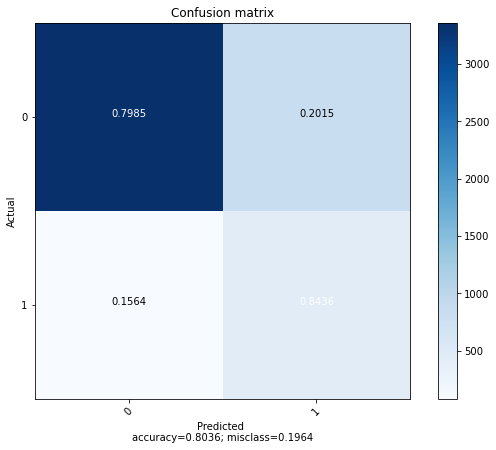

In [99]:
# cm = metrics.confusion_matrix(y_val, y_pred)
# plot_confusion_matrix(cm=cm,target_names=[0,1],title='Confusion matrix', cmap=None,normalize=True)
                          